In [14]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import learning_curve
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc

In [15]:
data = pd.read_csv("cleaned_data.csv")

In [16]:
# Map 'Yes' to 1 and 'No' to 0 in the 'Heart_Stroke' column
data['Heart_Stroke'] = data['Heart_Stroke'].map({'Yes': 1, 'No': 0})

# Label encoding for the 'Gender' column
label_encoder = LabelEncoder()
data['Gender'] = label_encoder.fit_transform(data['Gender'])

# Label encoding for binary categorical columns
label_encoder = LabelEncoder()
data['BPMeds'] = label_encoder.fit_transform(data['BPMeds'])
data['prevalentStroke'] = label_encoder.fit_transform(data['prevalentStroke'])
data['prevalentHyp'] = label_encoder.fit_transform(data['prevalentHyp'])

In [17]:
# One-hot encoding for the 'education' column
data = pd.get_dummies(data, columns=['education'], drop_first=True)

# Select features and target
X = data[['age', 'Gender', 'currentSmoker', 'cigsPerDay', 'BPMeds', 'prevalentStroke', 'prevalentHyp', 'diabetes', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose', 'education_postgraduate', 'education_primaryschool', 'education_uneducated']]
y = data['Heart_Stroke']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Optimal n_estimators: 150


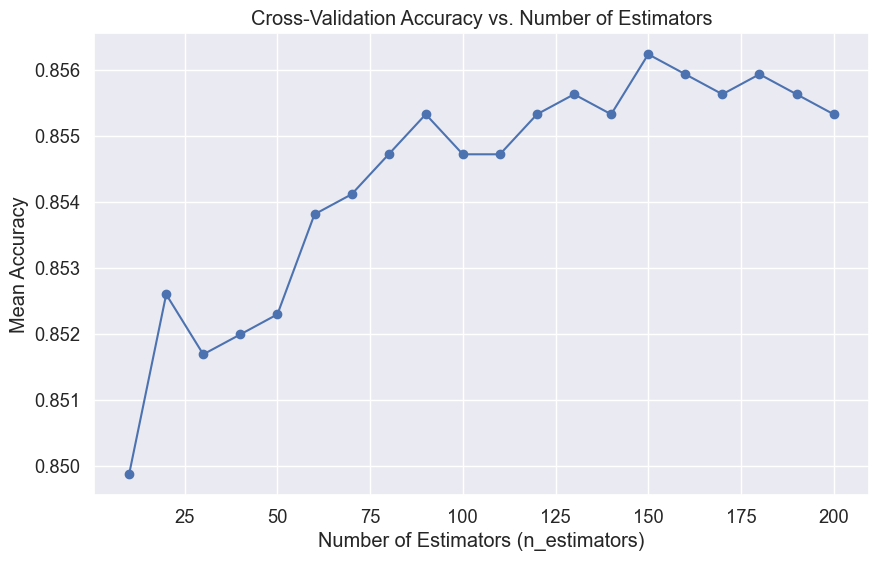

In [18]:
# Initialize an empty list to store mean cross-validation scores
cv_scores = []

# Define a range of n_estimators values to test
estimator_range = range(10, 201, 10)

# Iterate through different values of n_estimators
for n_estimators in estimator_range:
    # Initialize and train the Random Forest classifier with n_estimators
    rf_classifier = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
    
    # Perform cross-validation and calculate the mean accuracy score
    scores = cross_val_score(rf_classifier, X_train, y_train, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

# Find the n_estimators value with the highest cross-validation score
optimal_n_estimators = estimator_range[cv_scores.index(max(cv_scores))]

# Print the optimal n_estimators value
print(f'Optimal n_estimators: {optimal_n_estimators}')

# Plot the mean cross-validation scores for different n_estimators values
plt.figure(figsize=(10, 6))
plt.plot(estimator_range, cv_scores, marker='o', linestyle='-')
plt.title("Cross-Validation Accuracy vs. Number of Estimators")
plt.xlabel("Number of Estimators (n_estimators)")
plt.ylabel("Mean Accuracy")
plt.grid(True)
plt.show()

In [19]:
# Initialize and train the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=150, random_state=42)
rf_classifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred = rf_classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Print accuracy as a percentage with up to two decimal places
print(f'Random Forest Accuracy: {accuracy * 100:.2f}%')

Random Forest Accuracy: 86.22%


In [20]:
# Print the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Print a classification report
class_report = classification_report(y_test, y_pred)
print("\nClassification Report:")
print(class_report)

Confusion Matrix:
[[710   1]
 [113   3]]

Classification Report:
              precision    recall  f1-score   support

           0       0.86      1.00      0.93       711
           1       0.75      0.03      0.05       116

    accuracy                           0.86       827
   macro avg       0.81      0.51      0.49       827
weighted avg       0.85      0.86      0.80       827



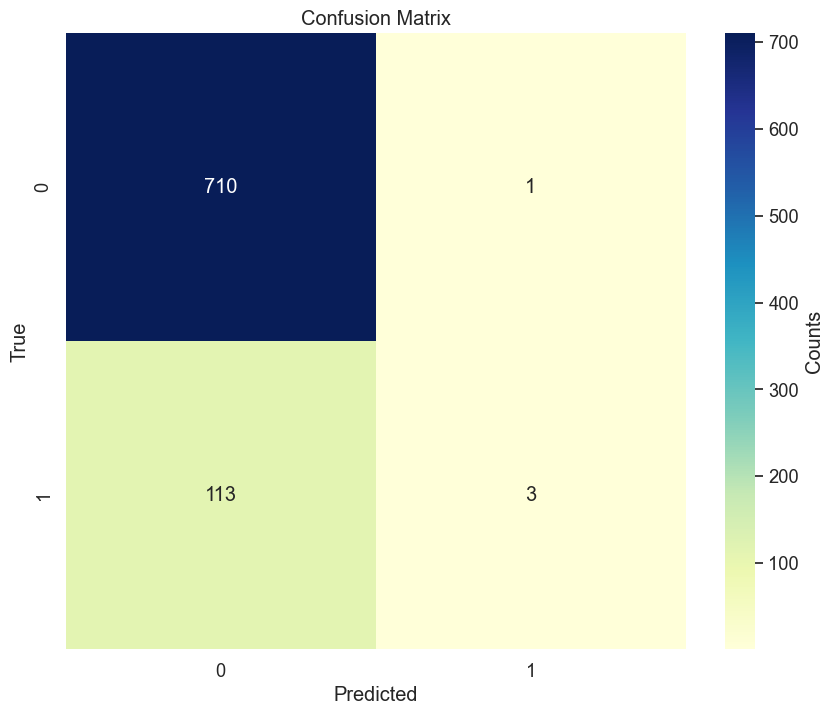

In [21]:
# Create a heatmap with a light color combination and a sidebar
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)  # Adjust font size for better readability

# Use a light color palette (e.g., "YlGnBu")
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="YlGnBu", cbar=True, cbar_kws={'label': 'Counts'})
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

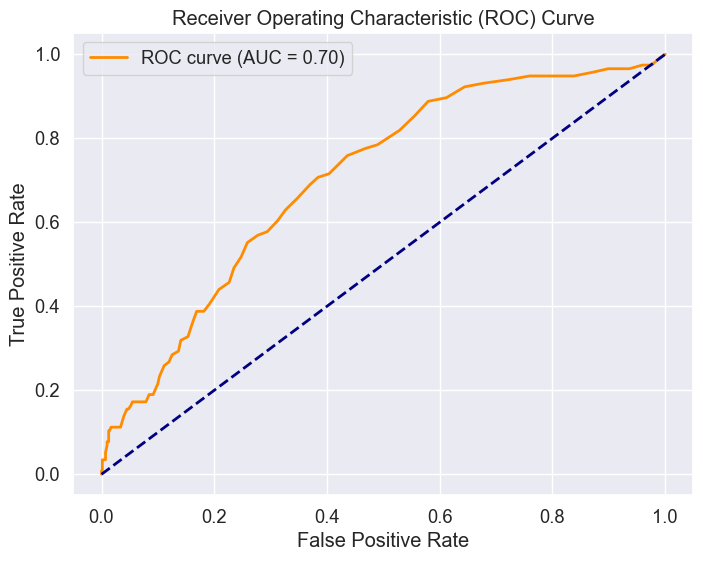

In [22]:
# Get predicted probabilities for the positive class
y_probs = rf_classifier.predict_proba(X_test)[:, 1]

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

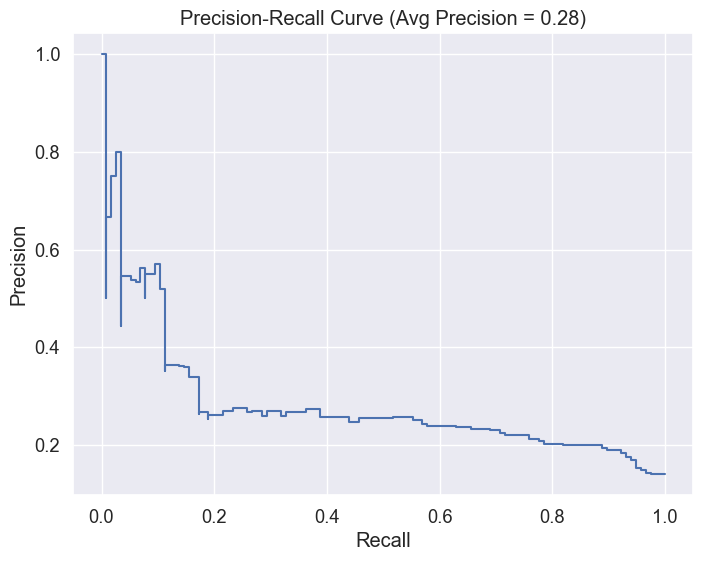

In [23]:
# Calculate precision-recall curve and average precision
precision, recall, _ = precision_recall_curve(y_test, y_probs)
average_precision = average_precision_score(y_test, y_probs)

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.step(recall, precision, color='b', where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve (Avg Precision = {average_precision:.2f})')
plt.show()

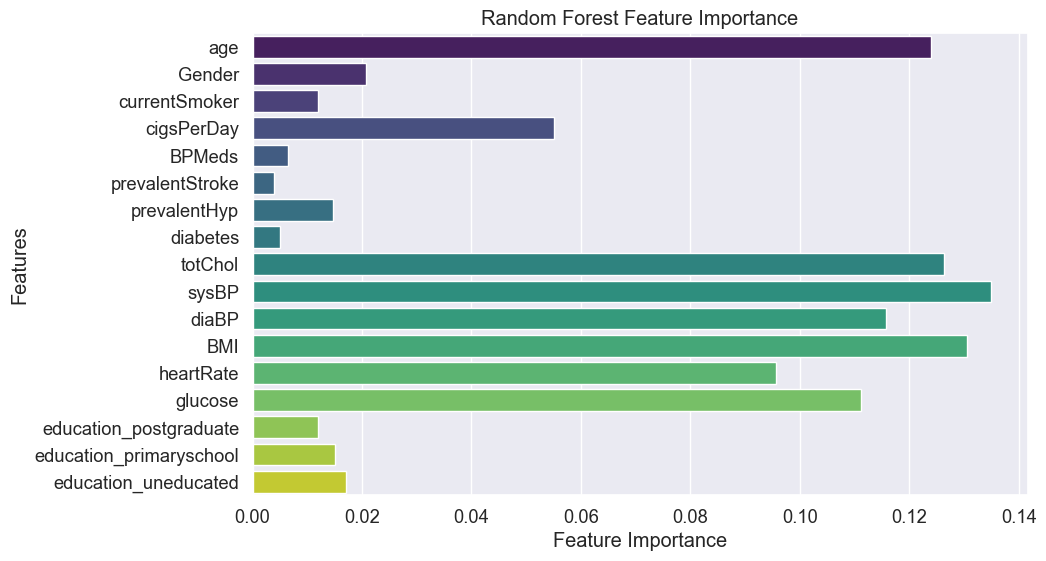

In [24]:
# Get feature importances from the trained Random Forest model
feature_importances = rf_classifier.feature_importances_

# Create a bar chart for feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances, y=X.columns, palette='viridis')
plt.title('Random Forest Feature Importance')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.show()

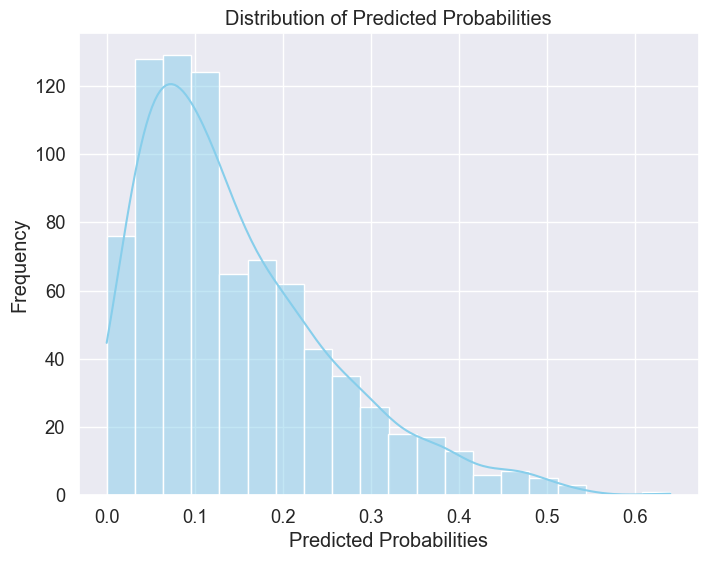

In [25]:
# Plot the distribution of predicted probabilities
plt.figure(figsize=(8, 6))
sns.histplot(y_probs, bins=20, kde=True, color='skyblue')
plt.title('Distribution of Predicted Probabilities')
plt.xlabel('Predicted Probabilities')
plt.ylabel('Frequency')
plt.show()

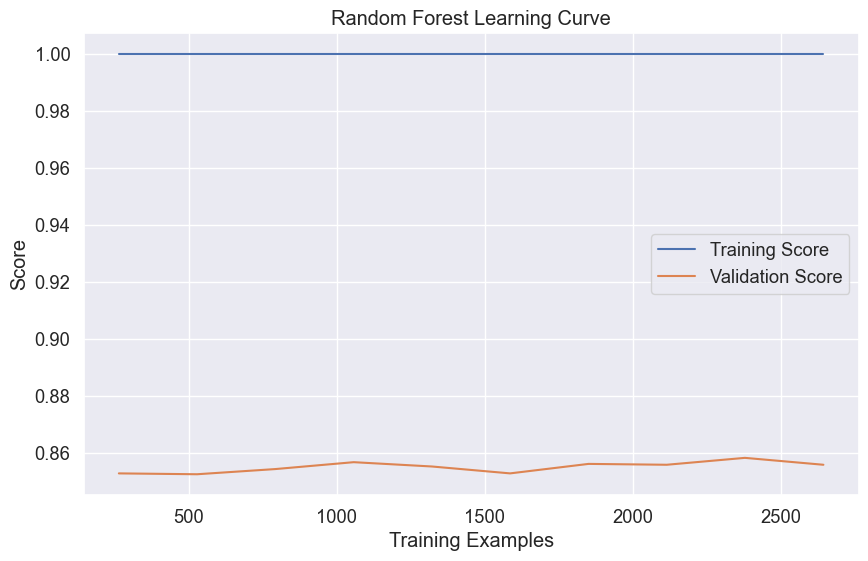

In [26]:
# Plot the learning curve
train_sizes, train_scores, test_scores = learning_curve(
    rf_classifier, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training Score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Validation Score')
plt.title('Random Forest Learning Curve')
plt.xlabel('Training Examples')
plt.ylabel('Score')
plt.legend()
plt.show()